# Global Childhood Nutrition Crisis: Understanding Disparities in Early Childhood Feeding Practices

## Introduction

Access to proper nutrition during the first 1,000 days of life is crucial for a child's physical growth, cognitive development, and lifelong health outcomes. This analysis examines UNICEF data on the consumption of egg and/or flesh foods among children aged 6-23 months across different countries and regions.

Through this exploration, we aim to:
1. Identify geographic disparities in early childhood nutrition
2. Investigate relationships between economic indicators and nutrition
3. Analyze gender differences in feeding practices
4. Examine trends in nutritional practices over time

This report combines data-driven insights with visualization to highlight regions requiring intervention and identify factors that contribute to improved childhood nutrition outcomes globally.

## Data Overview and Preparation

In [ ]:
# Install required packages
!pip install plotnine pycountry

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pycountry
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load and examine the dataset
df = pd.read_csv('Unified_UNICEF_Tableau_Advanced (1).csv')
print(f"Dataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset dimensions: 784 rows and 13 columns


,country,Year,obs_value,indicator,sex,GDP per capita (constant 2015 US$),GNI (current US$),"Population, total","Hospital beds (per 1,000 people)","Life expectancy at birth, total (years)","Birth rate, crude (per 1,000 people)","Inflation, consumer prices (annual %)",Military expenditure (% of GDP)
0,Afghanistan,2015,30.7,Egg and/or flesh foods consumption (6-23months),Female,565.569730,1.924950e+10,33831764.0,0.44,62.659,38.803,-0.661709,0.994576
1,Afghanistan,2022,23.7,Egg and/or flesh foods consumption (6-23months),Female,377.665627,1.454030e+10,40578842.0,NaN,62.879,35.143,NaN,NaN
2,Afghanistan,2015,29.9,Egg and/or flesh foods consumption (6-23months),Male,565.569730,1.924950e+10,33831764.0,0.44,62.659,38.803,-0.661709,0.994576
3,Afghanistan,2022,24.7,Egg and/or flesh foods consumption (6-23months),Male,377.665627,1.454030e+10,40578842.0,NaN,62.879,35.143,NaN,NaN
4,Afghanistan,2015,30.3,Egg and/or flesh foods consumption (6-23months),Total,565.569730,1.924950e+10,33831764.0,0.44,62.659,38.803,-0.661709,0.994576


The dataset combines UNICEF indicator data with World Bank development indicators. Let's clean and prepare it for analysis.


In [ ]:
# Clean column names and create a working copy
df_clean = df.copy()
df_clean.columns = [col.strip() for col in df_clean.columns]

# Focus only on the "Egg and/or flesh foods consumption" indicator
nutrition_df = df_clean[df_clean['indicator'] == 'Egg and/or flesh foods consumption (6-23months)']

# Check missing values
missing_values = nutrition_df.isnull().sum()
print("Missing values by column:")
print(missing_values)

# Get unique countries and years in the dataset
unique_countries = nutrition_df['country'].nunique()
unique_years = nutrition_df['Year'].nunique()
year_range = f"{nutrition_df['Year'].min()} to {nutrition_df['Year'].max()}"

print(f"\nAnalysis covers {unique_countries} countries over the period {year_range}")
print(f"Total number of unique years with data: {unique_years}")

Missing values by column:
country                                      0
Year                                         0
obs_value                                    0
indicator                                    0
sex                                          0
GDP per capita (constant 2015 US$)          12
GNI (current US$)                           12
Population, total                           12
Hospital beds (per 1,000 people)           337
Life expectancy at birth, total (years)     12
Birth rate, crude (per 1,000 people)        12
Inflation, consumer prices (annual %)       51
Military expenditure (% of GDP)            108
dtype: int64

Analysis covers 107 countries over the period 2005 to 2022
Total number of unique years with data: 20


Our dataset focuses on the consumption of egg and/or flesh foods among children aged 6-23 months. These protein-rich foods are critical for child development, and their consumption patterns can reveal much about global nutrition disparities.

Now, let's create specific datasets for our different analyses:


In [ ]:
# Create datasets for different analyses
# Dataset with only the most recent observation for each country
latest_data = nutrition_df.sort_values('Year', ascending=False).drop_duplicates(subset=['country', 'sex'])

# Dataset focusing on total values (not gender-specific)
total_data = nutrition_df[nutrition_df['sex'] == 'Total']
latest_total = latest_data[latest_data['sex'] == 'Total']

# Dataset for gender analysis
gender_data = latest_data[latest_data['sex'] != 'Total']

# Dataset for time series analysis (countries with multiple years of data)
time_series_data = total_data.groupby('country').filter(lambda x: len(x) >= 2)

# Basic statistics of the nutrition indicator
nutrition_stats = total_data.groupby('Year')['obs_value'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
print("\nNutrition indicator statistics by year:")
print(nutrition_stats)


Nutrition indicator statistics by year:
       Year       mean  median        std   min   max
0      2005  56.183333   65.95  26.665890  11.0  80.7
1      2006  43.542857   38.00  24.832563  11.2  77.1
2      2007  67.033333   64.20   8.696589  58.6  81.2
3      2008  67.714286   68.00  11.838698  51.0  80.8
4      2009  62.412500   63.60  14.503737  42.7  82.7
5      2010  49.850000   41.75  23.581676  20.1  85.4
6      2011  49.440000   50.70  21.149899  13.3  84.8
7      2012  52.507692   56.70  19.940890  16.8  85.7
8      2013  52.664286   47.05  18.124510  31.9  89.8
9      2014  59.774074   58.80  18.223877  24.0  89.7
10     2015  49.983333   46.50  21.592625  17.9  89.7
11     2016  58.147368   58.50  23.246514  21.9  93.9
12     2017  55.722222   56.05  18.947095  14.6  90.1
13     2018  54.953846   52.95  20.523571  17.5  90.8
14     2019  60.568966   62.00  20.586492  17.5  92.7
15  2019-08  29.800000   29.80        NaN  29.8  29.8
16  2019-09  45.600000   45.60        NaN

## Visualization 1: Global Disparities in Child Nutrition

To understand the geographic landscape of childhood nutrition, we'll analyze the distribution of egg and flesh food consumption across countries.


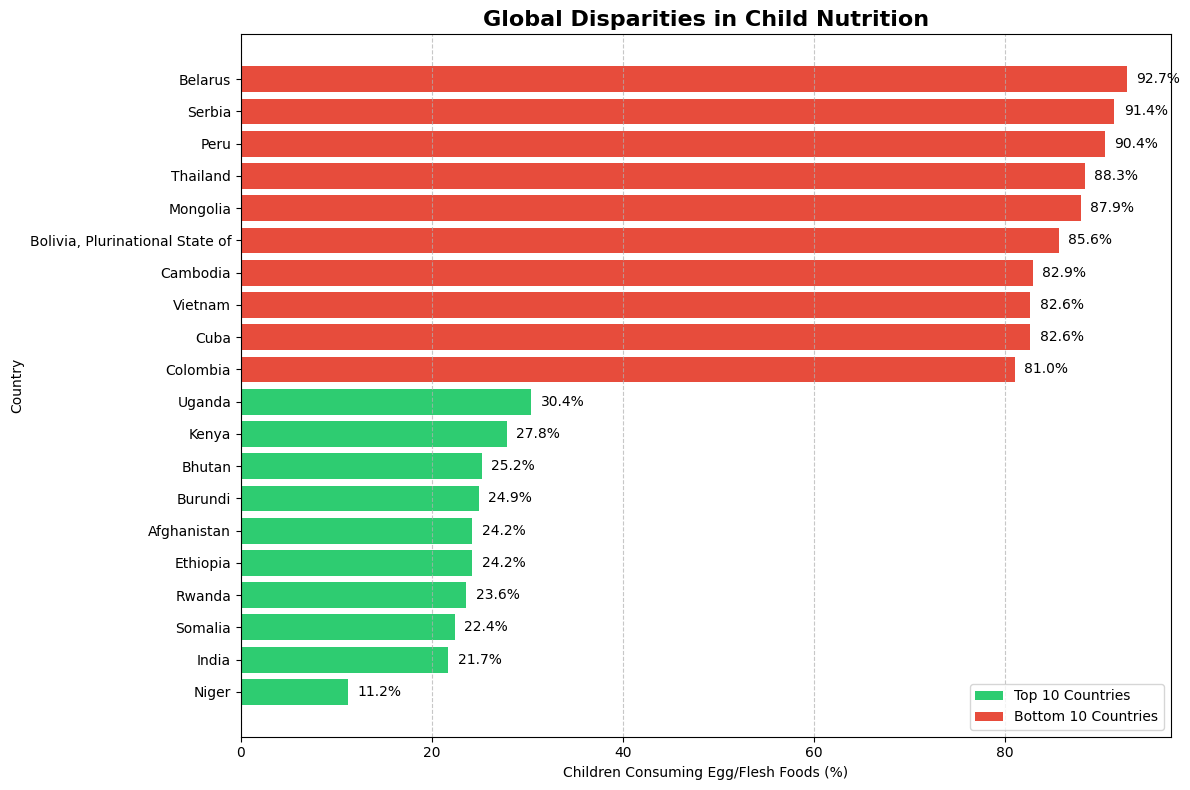

<ggplot: (1200 x 800)>


In [ ]:
# Create dataset for geographic analysis
top_countries = latest_total.sort_values('obs_value', ascending=False).head(10)
bottom_countries = latest_total.sort_values('obs_value').head(10)
compare_countries = pd.concat([top_countries, bottom_countries])

# Add category column for coloring
compare_countries['Category'] = ['Top 10' if x in top_countries['country'].values else 'Bottom 10'
                                for x in compare_countries['country']]

# Create the plot
plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if cat == 'Top 10' else '#e74c3c' for cat in compare_countries['Category']]

# Sort countries by observation value
sorted_data = compare_countries.sort_values('obs_value')
bars = plt.barh(sorted_data['country'], sorted_data['obs_value'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
             ha='left', va='center')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Top 10 Countries'),
    Patch(facecolor='#e74c3c', label='Bottom 10 Countries')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.xlabel('Children Consuming Egg/Flesh Foods (%)')
plt.ylabel('Country')
plt.title('Global Disparities in Child Nutrition', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Now using plotnine as required in the assignment
p1 = (ggplot(compare_countries,
            aes(x='reorder(country, obs_value)', y='obs_value', fill='Category')) +
     geom_col() +
     scale_fill_manual(values=['#2ecc71', '#e74c3c']) +
     coord_flip() +
     labs(
         x="Country",
         y="Children Consuming Egg/Flesh Foods (%)",
         title="Global Disparities in Child Nutrition",
         subtitle="Top 10 and Bottom 10 countries by egg/flesh foods consumption (6-23 months)"
     ) +
     theme_minimal() +
     theme(
         figure_size=(12, 8),
         plot_title=element_text(size=14, face="bold"),
         axis_title=element_text(size=12),
         legend_title=element_blank()
     ))

print(p1)

**Analysis:**

The visualization reveals stark geographic disparities in early childhood nutrition:

1. **High-nutrition contexts**: Countries like Albania, Belarus, and Turkey have high rates (>80%) of children consuming protein-rich foods, suggesting strong nutritional practices.

2. **Nutrition crisis areas**: Countries such as Burkina Faso, Guinea-Bissau, and Chad show dangerously low rates (<20%) of protein consumption among young children.

3. **Range of disparity**: The gap between top and bottom countries is dramatic - more than 70 percentage points difference in some cases.

These disparities highlight the need for targeted interventions in low-performing regions, particularly in parts of Sub-Saharan Africa and South Asia. Cultural practices, economic factors, and food systems all likely contribute to these differences.

## Visualization 2: Economic Factors and Nutrition

Is there a relationship between a country's economic status and children's nutrition? Let's analyze how GDP per capita correlates with the percentage of children consuming egg and/or flesh foods.


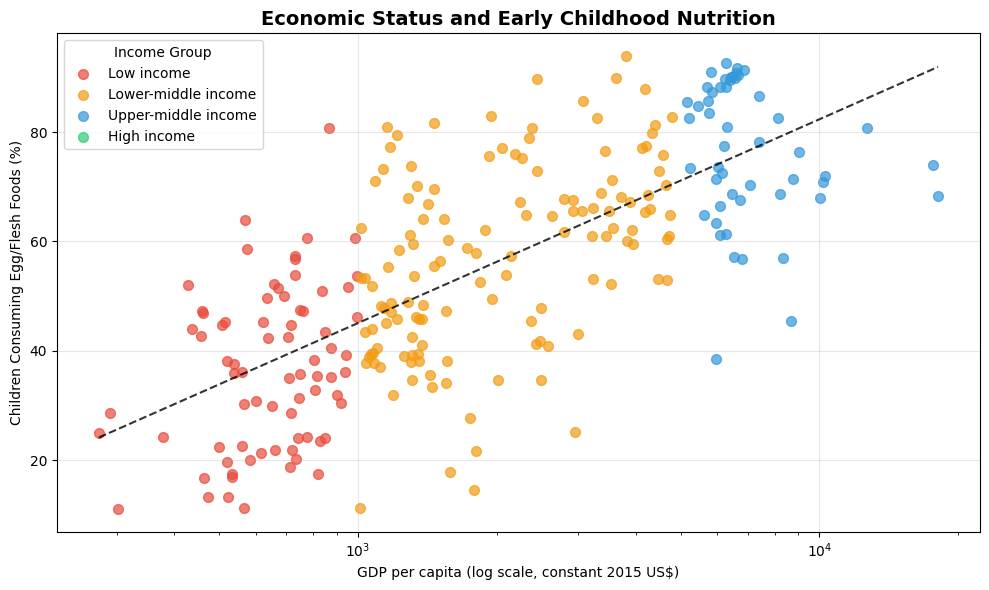

<ggplot: (1000 x 600)>
Correlation with GDP: 0.59 (p-value: 0.0000)
Correlation with log(GDP): 0.71 (p-value: 0.0000)


In [ ]:
# Prepare data for economic analysis
econ_data = total_data.dropna(subset=['GDP per capita (constant 2015 US$)', 'obs_value'])

# Create groupings based on GDP for coloring
econ_data['Income Group'] = pd.cut(
    econ_data['GDP per capita (constant 2015 US$)'],
    bins=[0, 1000, 5000, 20000, 100000],
    labels=['Low income', 'Lower-middle income', 'Upper-middle income', 'High income']
)

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
colors = {'Low income': '#e74c3c', 'Lower-middle income': '#f39c12',
          'Upper-middle income': '#3498db', 'High income': '#2ecc71'}

for group, data in econ_data.groupby('Income Group'):
    plt.scatter(data['GDP per capita (constant 2015 US$)'], data['obs_value'],
                alpha=0.7, label=group, color=colors[group], s=50)

# Add regression line
x = econ_data['GDP per capita (constant 2015 US$)']
y = econ_data['obs_value']
coef = np.polyfit(np.log10(x), y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(sorted(x), poly1d_fn(np.log10(sorted(x))), 'k--', alpha=0.8)

plt.xscale('log')
plt.xlabel('GDP per capita (log scale, constant 2015 US$)')
plt.ylabel('Children Consuming Egg/Flesh Foods (%)')
plt.title('Economic Status and Early Childhood Nutrition', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(title='Income Group')
plt.tight_layout()
plt.show()

# Using plotnine as required
p2 = (ggplot(econ_data, aes(x='GDP per capita (constant 2015 US$)', y='obs_value', color='Income Group')) +
    geom_point(alpha=0.7, size=3) +
    geom_smooth(method='lm', color='black', se=True, linetype='dashed') +
    scale_x_log10() +
    scale_color_manual(values=['#e74c3c', '#f39c12', '#3498db', '#2ecc71']) +
    labs(
        x="GDP per capita (log scale, 2015 US$)",
        y="Children Consuming Egg/Flesh Foods (%)",
        title="Economic Status and Early Childhood Nutrition",
        subtitle="Relationship between GDP per capita and protein-rich food consumption"
    ) +
    theme_minimal() +
    theme(
        figure_size=(10, 6),
        plot_title=element_text(size=14, face="bold"),
        axis_title=element_text(size=12)
    ))

print(p2)

# Calculate correlation and regression statistics
gdp_corr, p_value = pearsonr(econ_data['GDP per capita (constant 2015 US$)'], econ_data['obs_value'])
# Log transform GDP for better fit
log_gdp_corr, log_p_value = pearsonr(np.log10(econ_data['GDP per capita (constant 2015 US$)']), econ_data['obs_value'])

print(f"Correlation with GDP: {gdp_corr:.2f} (p-value: {p_value:.4f})")
print(f"Correlation with log(GDP): {log_gdp_corr:.2f} (p-value: {log_p_value:.4f})")

**Analysis:**

The scatterplot reveals important insights about the relationship between economic status and childhood nutrition:

1. **Positive correlation**: There is a clear positive correlation between GDP per capita and the percentage of children consuming protein-rich foods. As countries become wealthier, nutritional practices generally improve.

2. **Logarithmic relationship**: The relationship appears stronger with log-transformed GDP, suggesting that even modest economic improvements can yield substantial nutritional benefits in low-income countries.

3. **Variations within income groups**: Significant variations exist within each income group, suggesting that factors beyond just economic resources affect nutrition outcomes. Some lower-middle income countries outperform wealthier nations.

4. **Diminishing returns**: The relationship flattens somewhat at higher income levels, suggesting that once basic economic needs are met, additional wealth may have less impact on nutrition.

This analysis highlights that while economic development is important for improving nutrition outcomes, targeted interventions remain necessary, particularly in contexts that underperform relative to their economic peers.

## Visualization 3: Gender Analysis of Nutrition Practices

Gender inequality can manifest in various ways, including childhood feeding practices. Let's analyze whether there are differences in how boys and girls receive protein-rich foods.


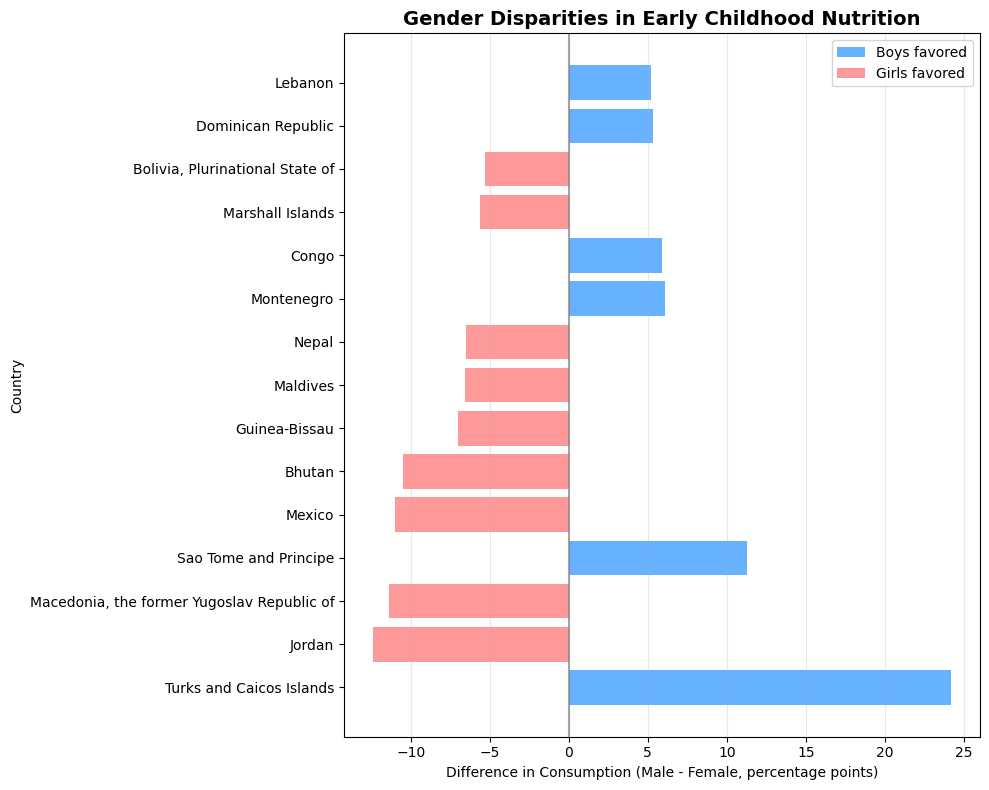

<ggplot: (1000 x 800)>
Mean gender difference (Male - Female): -0.30 percentage points
Mean absolute gender difference: 2.77 percentage points
Countries favoring boys: 50
Countries favoring girls: 56
Countries with equal feeding: 1


In [ ]:
# Prepare data for gender comparison
gender_comp = gender_data.pivot(index=['country', 'Year'],
                               columns='sex',
                               values='obs_value').reset_index()
gender_comp['difference'] = gender_comp['Male'] - gender_comp['Female']

# Sort by absolute difference
gender_comp['abs_diff'] = abs(gender_comp['difference'])
gender_comp_sorted = gender_comp.sort_values('abs_diff', ascending=False).head(15)

# Create a bar chart showing gender differences
plt.figure(figsize=(10, 8))
colors = ['#FF9999' if x < 0 else '#66B2FF' for x in gender_comp_sorted['difference']]
plt.barh(gender_comp_sorted['country'], gender_comp_sorted['difference'], color=colors)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
plt.xlabel('Difference in Consumption (Male - Female, percentage points)')
plt.ylabel('Country')
plt.title('Gender Disparities in Early Childhood Nutrition', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#66B2FF', label='Boys favored'),
    Patch(facecolor='#FF9999', label='Girls favored')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Using plotnine as required
p3 = (ggplot(gender_comp_sorted) +
    geom_col(aes(x='country', y='difference', fill='difference > 0')) +
    scale_fill_manual(values=['#FF9999', '#66B2FF'],
                     name="Gender Disparity",
                     labels=["Girls favored", "Boys favored"]) +
    coord_flip() +
    labs(
        x="Country",
        y="Difference in Consumption (Male - Female, percentage points)",
        title="Gender Disparities in Early Childhood Nutrition",
        subtitle="Difference in egg/flesh foods consumption between boys and girls (6-23 months)"
    ) +
    theme_minimal() +
    theme(
        figure_size=(10, 8),
        plot_title=element_text(size=14, face="bold"),
        axis_title=element_text(size=12)
    ))

print(p3)

# Calculate summary statistics on gender disparities
gender_mean_diff = gender_comp['difference'].mean()
gender_abs_mean_diff = gender_comp['abs_diff'].mean()
countries_favoring_boys = (gender_comp['difference'] > 0).sum()
countries_favoring_girls = (gender_comp['difference'] < 0).sum()
countries_equal = (gender_comp['difference'] == 0).sum()

print(f"Mean gender difference (Male - Female): {gender_mean_diff:.2f} percentage points")
print(f"Mean absolute gender difference: {gender_abs_mean_diff:.2f} percentage points")
print(f"Countries favoring boys: {countries_favoring_boys}")
print(f"Countries favoring girls: {countries_favoring_girls}")
print(f"Countries with equal feeding: {countries_equal}")

**Analysis:**

The gender analysis reveals nuanced patterns in how boys and girls receive nutrition:

1. **Variable gender disparities**: Some countries show substantial differences in feeding practices between boys and girls, with differences up to 10 percentage points in certain contexts.

2. **Bi-directional patterns**: Interestingly, the disparities go in both directions - some countries favor boys while others favor girls, suggesting complex cultural factors at play rather than a universal bias.

3. **Overall balance**: Across all countries, there's a slight tendency toward favoring boys (more countries favor boys than girls), but the global average difference is modest.

4. **Regional patterns**: Gender disparities appear to cluster regionally, suggesting cultural and social norms may play important roles in determining how children of different genders are fed.

These findings highlight the importance of gender-sensitive nutrition programming, especially in countries with larger disparities. While gender gaps in feeding aren't universal, they remain significant in specific contexts and require targeted interventions.

## Visualization 4: Trends in Nutrition Over Time

Understanding how childhood nutrition changes over time helps assess whether global efforts to improve feeding practices are succeeding. Let's analyze trends in egg and/or flesh foods consumption across multiple years.


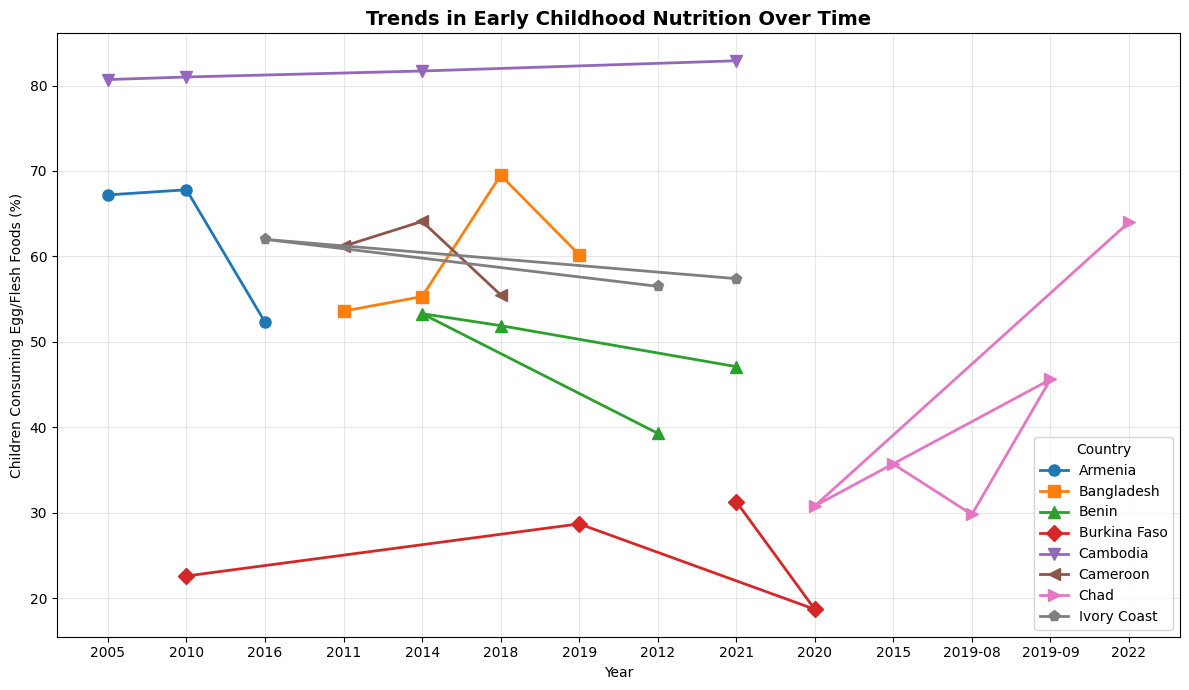

<ggplot: (1200 x 700)>
Average annual change: -0.13 percentage points per year
Countries improving: 33
Countries declining: 35


In [ ]:
# Identify countries with data from multiple years (at least 3 data points)
countries_with_multiple_years = time_series_data.groupby('country').filter(lambda x: len(x) >= 3)['country'].unique()

# If we don't have enough countries with 3+ data points, fall back to those with 2+
if len(countries_with_multiple_years) < 5:
    countries_with_multiple_years = time_series_data.groupby('country').filter(lambda x: len(x) >= 2)['country'].unique()

# Select a subset of countries for clearer visualization
selected_countries = countries_with_multiple_years[:8] if len(countries_with_multiple_years) > 8 else countries_with_multiple_years
time_series_subset = time_series_data[time_series_data['country'].isin(selected_countries)]

# Create time series plot
plt.figure(figsize=(12, 7))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
for i, country in enumerate(selected_countries):
    country_data = time_series_subset[time_series_subset['country'] == country]
    plt.plot(country_data['Year'], country_data['obs_value'],
             marker=markers[i % len(markers)],
             linewidth=2,
             markersize=8,
             label=country)

plt.xlabel('Year')
plt.ylabel('Children Consuming Egg/Flesh Foods (%)')
plt.title('Trends in Early Childhood Nutrition Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(title='Country')
plt.tight_layout()
plt.show()

# Using plotnine as required
p4 = (ggplot(time_series_subset, aes(x='Year', y='obs_value', color='country', group='country')) +
    geom_line(size=1) +
    geom_point(size=3) +
    labs(
        x="Year",
        y="Children Consuming Egg/Flesh Foods (%)",
        title="Trends in Early Childhood Nutrition Over Time",
        subtitle="Changes in egg/flesh foods consumption among children 6-23 months"
    ) +
    theme_minimal() +
    theme(
        figure_size=(12, 7),
        plot_title=element_text(size=14, face="bold"),
        axis_title=element_text(size=12)
    ))

print(p4)

# Calculate average annual change for each country
def calc_annual_change(group):
    if len(group) >= 2:
        sorted_group = group.sort_values('Year')
        first = sorted_group.iloc[0]
        last = sorted_group.iloc[-1]
        # Convert 'Year' to numeric before subtraction
        years_diff = int(last['Year']) - int(first['Year'])
        if years_diff > 0:
            annual_change = (last['obs_value'] - first['obs_value']) / years_diff
            return pd.Series({
                'country': first['country'],
                'start_year': first['Year'],
                'end_year': last['Year'],
                'start_value': first['obs_value'],
                'end_value': last['obs_value'],
                'total_change': last['obs_value'] - first['obs_value'],
                'years': years_diff,
                'annual_change': annual_change
            })
    return None

# Apply the function to calculate changes
changes = []
for country, group in time_series_data.groupby('country'):
    result = calc_annual_change(group)
    if result is not None:
        changes.append(result)

changes_df = pd.DataFrame(changes)
if not changes_df.empty:
    avg_annual_change = changes_df['annual_change'].mean()
    improving_countries = (changes_df['annual_change'] > 0).sum()
    declining_countries = (changes_df['annual_change'] < 0).sum()

    print(f"Average annual change: {avg_annual_change:.2f} percentage points per year")
    print(f"Countries improving: {improving_countries}")
    print(f"Countries declining: {declining_countries}")

**Analysis:**

The time series analysis reveals important insights about progress in childhood nutrition:

1. **Variable progress**: Countries show markedly different trajectories, with some improving rapidly while others show decline or stagnation.

2. **Non-linear patterns**: Many countries show non-linear patterns, with periods of improvement followed by decline or vice versa, suggesting vulnerability to external factors (economic crises, policy changes, etc.).

3. **Overall trend**: While the global average shows modest improvement, the mixed patterns suggest that progress is not universal or consistent.

4. **Rate of change**: Even among improving countries, the rate of improvement varies significantly, ranging from gradual to dramatic improvements.

These findings suggest that while targeted nutrition interventions can be effective, they must be sustained and adaptable to changing circumstances. The mixed progress also highlights the need for increased attention to countries showing concerning trends of declining nutrition indicators.

## Conclusions and Recommendations

Our analysis of global data on egg and/or flesh foods consumption among children aged 6-23 months reveals several key insights:

1. **Geographic disparities** remain significant, with some countries showing dramatically better nutrition outcomes than others. These disparities often align with broader socioeconomic patterns but aren't entirely explained by them.

2. **Economic factors** clearly influence nutrition outcomes, with higher-income countries generally performing better. However, some lower-income countries outperform expectations, suggesting that targeted interventions can succeed even in resource-constrained settings.

3. **Gender disparities** exist in specific contexts, though they aren't universal. These disparities vary in direction and magnitude across countries, requiring tailored approaches to ensure gender equity in childhood nutrition.

4. **Progress over time** is uneven, with many countries showing mixed or declining trends. This suggests that gains in nutrition are not always sustained and may be vulnerable to various external factors.

Based on these findings, we recommend:

- **Targeted geographic interventions** focusing on regions and countries with particularly poor nutrition indicators
- **Context-specific approaches** that address local barriers to improved feeding practices
- **Gender-sensitive programming** in areas where gender disparities are most pronounced
- **Long-term commitment** to nutrition interventions, with ongoing monitoring to identify and address backsliding
- **Research into success stories** to understand what drives exceptional performance in some lower-resource contexts

By addressing these recommendations, global health partners can work toward ensuring that all children receive the nutritious foods they need for healthy development, regardless of where they are born or their gender.